**Customer Loyalty Analysis**

The dataset we are working with is IBM’s customer churn data. The dataset was taken from the website: 
https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [165]:
df = pd.read_csv("customer churn analysis.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Cleaning

In [168]:
data1 = df.copy()
data1.TotalCharges = pd.to_numeric(data1.TotalCharges, errors='coerce')
data1.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [118]:
data1.loc[data1 ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [119]:
data1.TotalCharges = data1.TotalCharges.fillna(data1.TotalCharges.interpolate())
#data1 for having tenure values instead of groups

In [120]:
print(data1['tenure'].max())
data = data1.copy()

72


In [121]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

data['tenure_group'] = pd.cut(data.tenure, range(1, 80, 12), right=False, labels=labels)

In [122]:
data['tenure_group'].value_counts()
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


In [123]:
#exploration

In [124]:
data.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


In [125]:
churn_value_count = pd.DataFrame(100*df['Churn'].value_counts()/len(df['Churn']))
churn_value_count.reset_index().set_axis(['churn','value'], axis=1, inplace=True)
churn_value_count


,Churn
No,73.463013
Yes,26.536987


[(0.5725490196078431, 0.5725490196078431, 1.0), (1.0, 0.5725490196078431, 0.5725490196078431)]


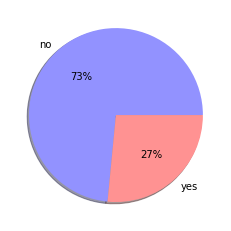

In [126]:
colors = sns.color_palette('bwr')[1:2] 
colors.append((sns.color_palette('bwr')[4]))
plt.pie(np.ravel(churn_value_count), labels = ["no","yes"], colors = colors, autopct='%.0f%%',shadow=True)
print(colors)

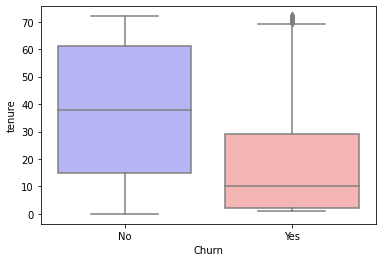

In [127]:
sns.boxplot(x = data1.Churn, y = data1.tenure, palette='bwr')

Text(0.5, 1.0, 'Monthly charges by churn')

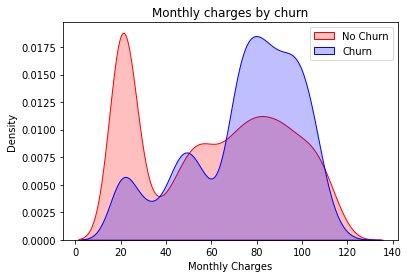

In [128]:
Mth = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == "No") ],
                color="Red", shade = True)
Mth = sns.kdeplot(data.MonthlyCharges[(data["Churn"] == "Yes") ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')


Text(0.5, 1.0, 'Total charges by churn')

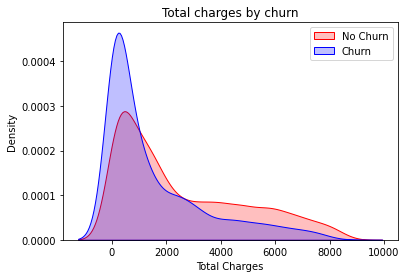

In [129]:
Tot = sns.kdeplot(data.TotalCharges[(data["Churn"] == "No") ],
                color="Red", shade = True)
Tot = sns.kdeplot(data.TotalCharges[(data["Churn"] == "Yes") ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

Text(0.5, 1.0, 'Total charges by churn')

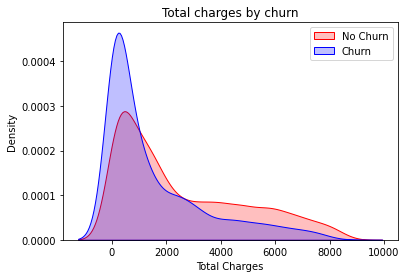

In [130]:
Tot = sns.kdeplot(data1.TotalCharges[(data1["Churn"] == "No") ],
                color="Red", shade = True)
Tot = sns.kdeplot(data1.TotalCharges[(data1["Churn"] == "Yes") ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

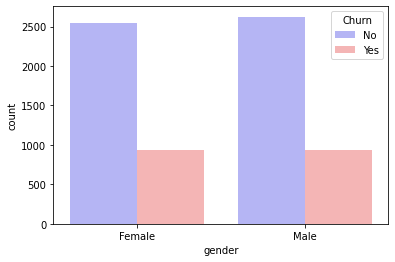

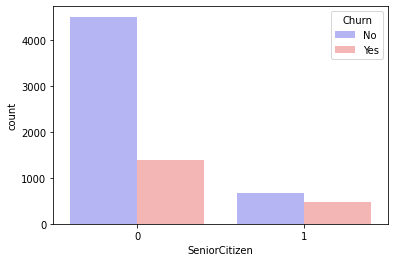

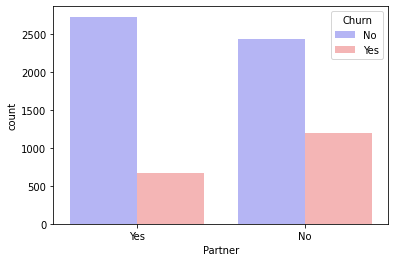

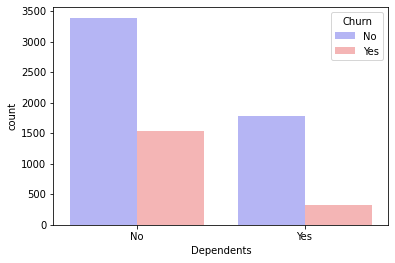

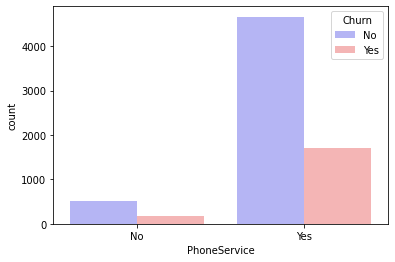

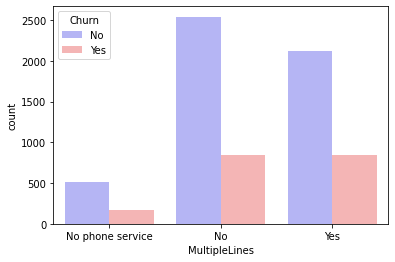

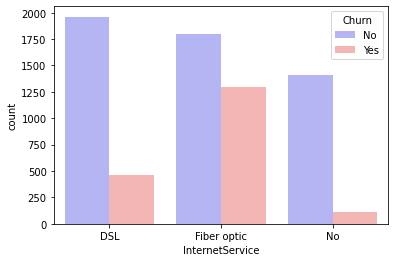

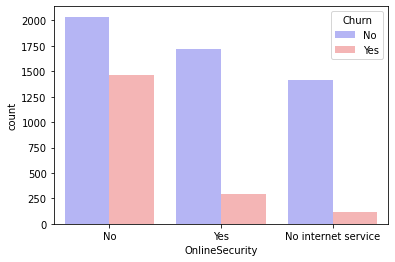

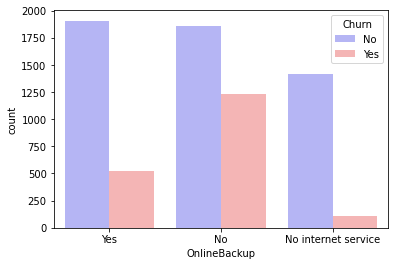

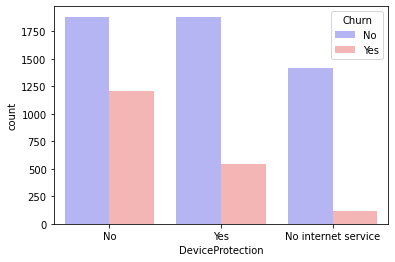

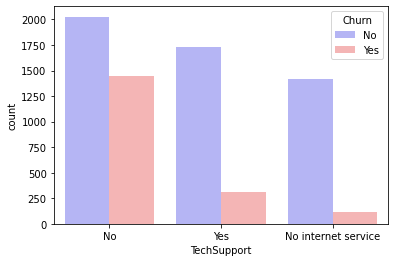

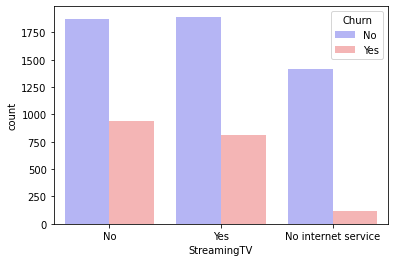

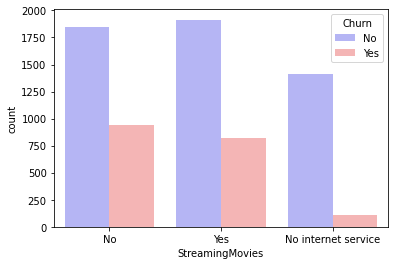

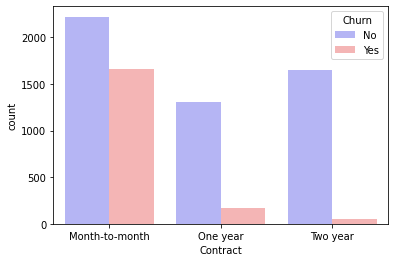

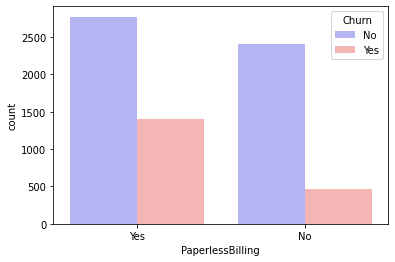

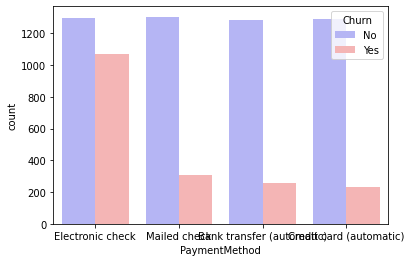

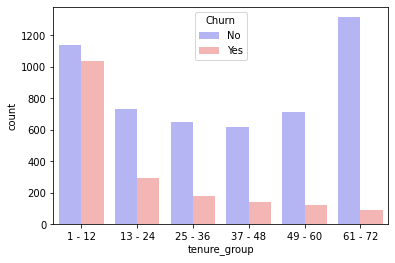

In [131]:
list = enumerate(data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges']))
lst=[]
for i, predictor in list:
    plt.figure(i)
    lst.append(sns.countplot(data=data, x=predictor, hue='Churn',palette='bwr'))
plt.show()

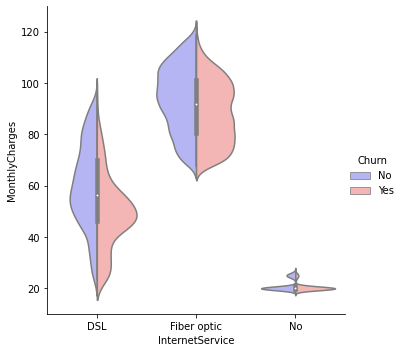

In [132]:
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="violin", split=True, palette="bwr", data=data)
#It's interesting how customers with DSL (slower connection) and higher charges are less probable to churn.


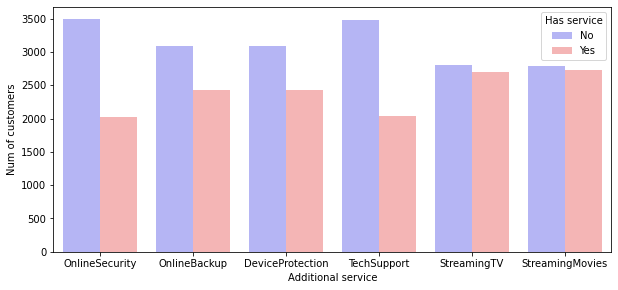

In [133]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
data1 = pd.melt(data[data["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=data1, x='variable', hue='Has service', palette="bwr")
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

#additional internet services like online security, online backup, device protection, tech support are not 
#preferred by many users but user who have opted for these services show high retention rate from the above graphs
#hence the company has to focus on advertising these services to its customers to decrease the customer churn rate 

In [134]:
data_dummies = pd.get_dummies(data)
data_dummies.head() 

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,0,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
4,0,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0


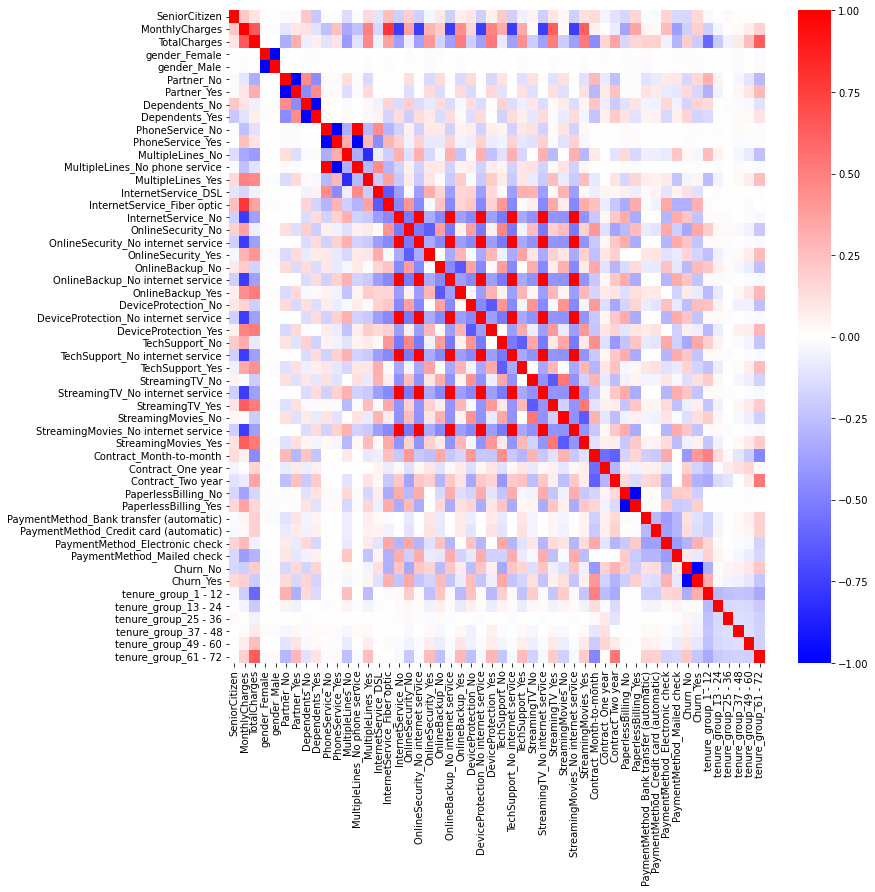

In [135]:
plt.figure(figsize=(12,12))
sns.heatmap(data_dummies.corr(),cmap='bwr')


In [136]:
telco_data = data_dummies.copy()
telco_data

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
2,0,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
4,0,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0
7039,0,103.20,7362.90,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1
7040,0,29.60,346.45,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
7041,1,74.40,306.60,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0


In [137]:
input = telco_data.drop(['Churn_No','Churn_Yes'],axis=1)
input

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0
7039,0,103.20,7362.90,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
7040,0,29.60,346.45,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
7041,1,74.40,306.60,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0


In [138]:
output= data['Churn'].replace({'No': 0,'Yes': 1})
output

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

**Model Building**

In [139]:
input_train,input_test,output_train,output_test=train_test_split(input,output,test_size=0.2)

In [140]:
model_score_list1 = []

In [141]:
#before smoteenn
#DT 
dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)
dt.fit(input_train,output_train)
output_pred = dt.predict(input_test)
model_score_list1.append(dt.score(input_test,output_test))
dt.score(input_test,output_test)


0.7622427253371186

In [142]:
print(classification_report(output_test, output_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1030
           1       0.58      0.44      0.50       379

    accuracy                           0.76      1409
   macro avg       0.69      0.66      0.67      1409
weighted avg       0.75      0.76      0.75      1409



In [143]:
#RF
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
rf.fit(input_train,output_train)
output_pred=rf.predict(input_test)
model_score_list1.append(rf.score(input_test,output_test))
rf.score(input_test,output_test)


0.7927608232789212

In [144]:
print(classification_report(output_test, output_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1030
           1       0.65      0.49      0.56       379

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [145]:
#SVM
rf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf.fit(input_train,output_train)
output_pred=rf.predict(input_test)
model_score_list1.append(rf.score(input_test,output_test))
rf.score(input_test,output_test)

0.7899219304471257

In [146]:
print(classification_report(output_test, output_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1030
           1       0.65      0.48      0.55       379

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [147]:
#KNN
rf = KNeighborsClassifier(n_neighbors=25)
rf.fit(input_train,output_train)
output_pred=rf.predict(input_test)
model_score_list1.append(rf.score(input_test,output_test))
rf.score(input_test,output_test)

0.7721788502484032

In [148]:
print(classification_report(output_test, output_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1030
           1       0.63      0.37      0.46       379

    accuracy                           0.77      1409
   macro avg       0.71      0.64      0.66      1409
weighted avg       0.75      0.77      0.75      1409



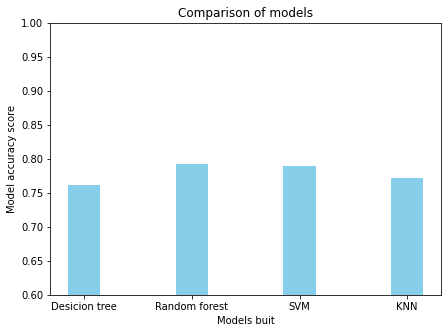

In [163]:
models = ['Desicion tree','Random forest','SVM','KNN']
fig = plt.figure(figsize = (7, 5))
#  Bar plot
plt.bar(models,model_score_list1, color ='skyblue',width = 0.3)
plt.ylim(0.6,1.0)
plt.xlabel("Models buit")
plt.ylabel("Model accuracy score")
plt.title("Comparison of models")
plt.show()

In [150]:
model_score_list2 = []

In [151]:
#after smoteenn
sm = SMOTEENN()
input_resampled, output_resampled = sm.fit_resample(input,output)
ir_train,ir_test,or_train,or_test=train_test_split(input_resampled, output_resampled,test_size=0.2)

In [152]:
#DT
dt_s=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)
dt_s.fit(ir_train,or_train)
or_predict = dt_s.predict(ir_test)
model_score_r = dt_s.score(ir_test, or_test)
model_score_list2.append(model_score_r)
print(model_score_r)

0.9187339606501284


In [153]:
print(classification_report(or_test, or_predict))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       535
           1       0.92      0.94      0.93       634

    accuracy                           0.92      1169
   macro avg       0.92      0.92      0.92      1169
weighted avg       0.92      0.92      0.92      1169



In [154]:
#RF after SMOTEENN
rf_s=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
rf_s.fit(ir_train,or_train)
or_predict = rf_s.predict(ir_test)
model_score_r1 = rf_s.score(ir_test, or_test)
model_score_list2.append(model_score_r1)
print(model_score_r1)

0.9213002566295979


In [155]:
print(classification_report(or_test, or_predict))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       535
           1       0.89      0.97      0.93       634

    accuracy                           0.92      1169
   macro avg       0.93      0.92      0.92      1169
weighted avg       0.92      0.92      0.92      1169



In [156]:
#SVM after SMOTEENN
rf_s = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf_s.fit(ir_train,or_train)
or_predict = rf_s.predict(ir_test)
model_score_list2.append(rf_s.score(ir_test, or_test))
rf_s.score(ir_test, or_test)

0.9435414884516681

In [157]:
print(classification_report(or_test, or_predict))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       535
           1       0.94      0.96      0.95       634

    accuracy                           0.94      1169
   macro avg       0.94      0.94      0.94      1169
weighted avg       0.94      0.94      0.94      1169



In [158]:
#KNN after SMOTEENN
rf_s = KNeighborsClassifier(n_neighbors=2)
rf_s.fit(ir_train,or_train)
or_predict = rf_s.predict(ir_test)
model_score_list2.append(rf_s.score(ir_test, or_test))
rf_s.score(ir_test, or_test)

0.9820359281437125

In [159]:
print(classification_report(or_test, or_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       535
           1       0.99      0.98      0.98       634

    accuracy                           0.98      1169
   macro avg       0.98      0.98      0.98      1169
weighted avg       0.98      0.98      0.98      1169



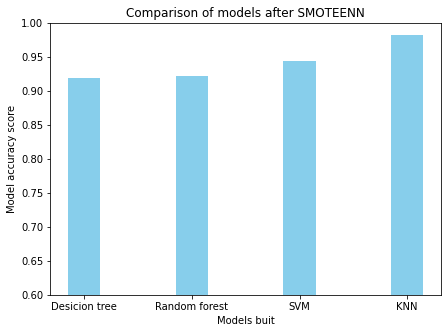

In [164]:
models = ['Desicion tree','Random forest','SVM','KNN']
fig = plt.figure(figsize = (7, 5))
#  Bar plot
plt.bar(models,model_score_list2, color ='skyblue',width = 0.3)
plt.ylim(0.6,1.0)
plt.xlabel("Models buit")
plt.ylabel("Model accuracy score")
plt.title("Comparison of models after SMOTEENN")
plt.show()

In [161]:
#feature impotrance
#confusion matrix

In [162]:
imp = pd.Series(data=rf_s.feature_importances_, index=ir_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, orient='h',palette='bwr')

AttributeError: ignored

In [ ]:
filename = 'model.sav'
pickle.dump(rf_s,open(filename,'wb'))

In [ ]:
load_model = pickle.load(open(filename,'rb'))
model_score_r1 = load_model.score(ir_test, or_test)
model_score_r1